In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels.stats.api as sms

from src.utils import pmf_utils

In [23]:
from config import dir_config, main_config

base_data_dir = Path(dir_config.data.base)
raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)

filtered_data = pd.read_csv(Path(processed_dir, "processed_data_accu_60_filtered.csv"), index_col=None)
processed_metadata = pd.read_csv(Path(processed_dir, "processed_metadata_accu_60.csv"), index_col=None)

# # exclude the following subjects where categorization score is more than 3
# reject_subs = processed_metadata.loc[processed_metadata["categorization_score"] > 3]['subject_id']
# processed_metadata = processed_metadata.loc[~processed_metadata["subject_id"].isin(reject_subs)]


In [24]:
processed_metadata['subject_id'].unique(), processed_metadata['subject_id'].unique().shape

(array(['P1', 'P3', 'P4', 'P6', 'P7', 'P9', 'P11', 'P12', 'P13', 'P17',
        'P18', 'P19', 'P20', 'P22', 'P23', 'P24', 'CG', 'COH', 'MBY', 'DP',
        'FUR', 'LBR', 'MAR', 'SMI', 'PAM', 'RW', 'BBK', 'BER', 'DCAM',
        'ALE', 'DMO', 'RBA', 'RDE', 'SGA', 'LHO'], dtype=object),
 (35,))

In [25]:
filtered_data['subject_id'].unique()

array(['PAM', 'ALE', 'DMO', 'P11', 'COH', 'P20', 'CG', 'BER', 'P23', 'P6',
       'MAR', 'RBA', 'LBR', 'P12', 'LHO', 'SGA', 'P4', 'RDE', 'RW', 'P17',
       'DP', 'SMI', 'P13', 'DCAM', 'P7', 'P22', 'P9', 'FUR', 'P18', 'P1',
       'P3', 'P24', 'P19', 'BBK', 'MBY'], dtype=object)

In [26]:
# Getting indices of on and off treatment from same subject in processed metadata
subject_treatment_idx = pd.DataFrame(columns=['subject', 'off', 'on'])
treatment_idx = pd.DataFrame(columns=['subject', 'off', 'on'])

for idx, sub in enumerate(processed_metadata['subject_id'].unique()):
    sub_df = processed_metadata.loc[processed_metadata['subject_id'] == sub]
    subject_treatment_idx.loc[idx] = [sub, sub_df.loc[sub_df['treatment'] == 'OFF'].index[0], sub_df.loc[sub_df['treatment'] == 'ON'].index[0]]

    # print(f"Subject {sub} with {sub_df['subject_id'].values}")
    print(f"Subject {sub} has {sub_df['categorization_score'].values} categorization_score")
    if np.sum(np.isnan(sub_df['categorization_score'])) == 0:
        # put off treatment first column and on treatment second column one row at a time
        treatment_idx.loc[idx] = [sub, sub_df.loc[sub_df['treatment'] == 'OFF'].index[0], sub_df.loc[sub_df['treatment'] == 'ON'].index[0]]

    # break

Subject P1 has [0.1958042  0.43636364] categorization_score
Subject P3 has [nan nan] categorization_score
Subject P4 has [0.8        0.36923077] categorization_score
Subject P6 has [1.03896104 0.91428571] categorization_score
Subject P7 has [1.93939394 0.8       ] categorization_score
Subject P9 has [0.76190476 0.58181818] categorization_score
Subject P11 has [0.         1.33333333] categorization_score
Subject P12 has [1.12       3.55555556] categorization_score
Subject P13 has [0.43636364 0.56      ] categorization_score
Subject P17 has [1.00699301 0.31111111] categorization_score
Subject P18 has [0.16       1.09090909] categorization_score
Subject P19 has [3.73333333 1.11363636] categorization_score
Subject P20 has [0.         0.35109718] categorization_score
Subject P22 has [0.0969697 0.       ] categorization_score
Subject P23 has [0.45714286 0.15311005] categorization_score
Subject P24 has [0.93506494 2.66666667] categorization_score
Subject CG has [nan nan] categorization_score


In [27]:
treatment_idx

,subject,off,on
0,P1,0,1
2,P4,4,5
3,P6,6,7
4,P7,8,9
5,P9,11,10
6,P11,13,12
7,P12,15,14
8,P13,16,17
9,P17,18,19
10,P18,21,20


In [28]:
original_all_subjects = ['CG', 'COH', 'MBY', 'DP', 'FUR', 'LBR', 'MAR', 'SMI', 'RW', 'SGA']
original_trem_subjects = ['DP', 'FUR', 'LBR', 'MAR', 'SMI']
original_brady_subjects = ['CG', 'COH', 'MBY', 'RW', 'SGA']

new_trem_subjects = processed_metadata.loc[processed_metadata['categorization'] == 'tremor_dominant']['subject_id'].unique()
new_brady_subjects = processed_metadata.loc[processed_metadata['categorization'] == 'bradykinesia_dominant']['subject_id'].unique()
new_intermediate_subjects = processed_metadata.loc[processed_metadata['categorization'] == 'intermediate']['subject_id'].unique()
print(f"New tremor_subjects: {len(new_trem_subjects)} \t {new_trem_subjects}")
print(f"New brady_subjects: {len(new_brady_subjects)} \t{new_brady_subjects}")
print(f"New intermediate_subjects: {len(new_intermediate_subjects)} \t{new_intermediate_subjects}")

new_all_subjects = subject_treatment_idx['subject'].unique()
new_subtype_subjects = treatment_idx['subject'].unique()
# print(f"New all_subjects: {new_all_subjects}")
# print(f"New subtype_subjects: {new_subtype_subjects}")

New tremor_subjects: 7 	 ['P6' 'P7' 'P11' 'P12' 'P17' 'P18' 'P19']
New brady_subjects: 7 	['P1' 'P4' 'P9' 'P13' 'P20' 'P22' 'P23']
New intermediate_subjects: 1 	['P24']


### Psychometric Function plots

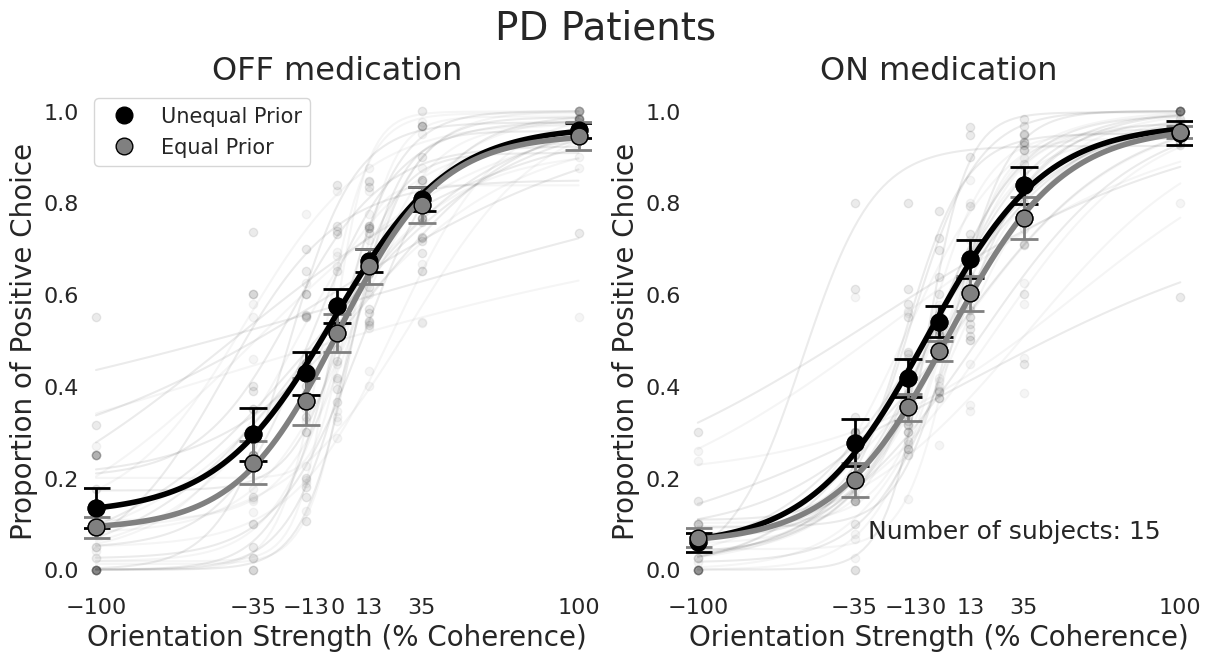

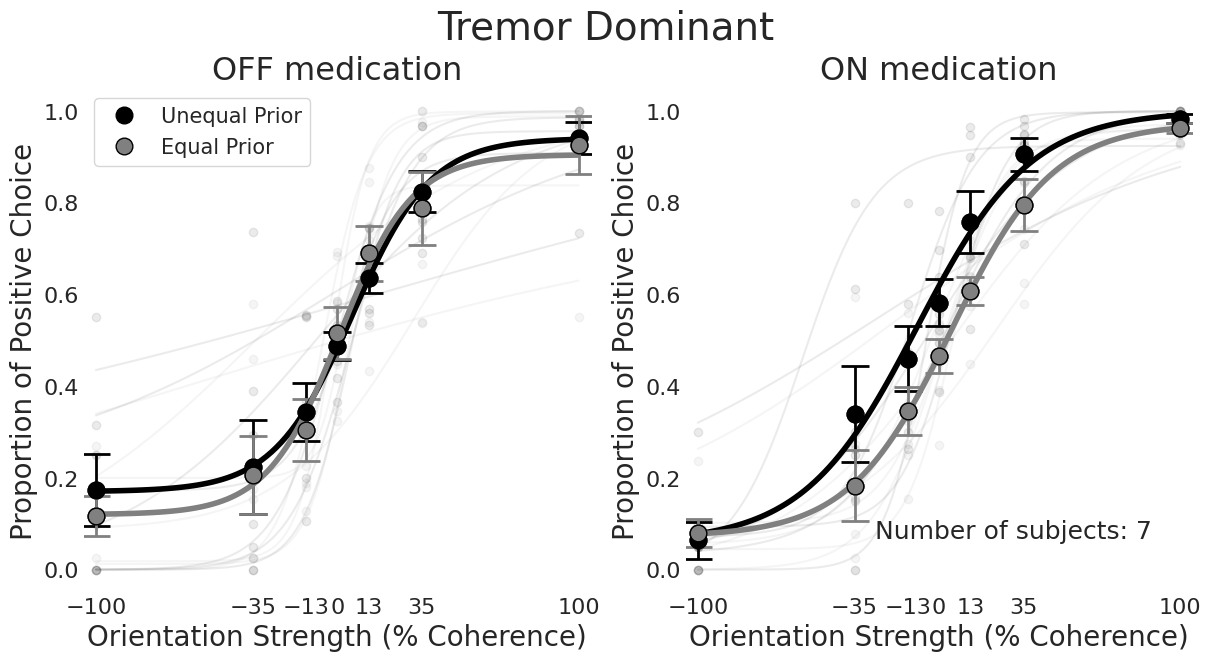

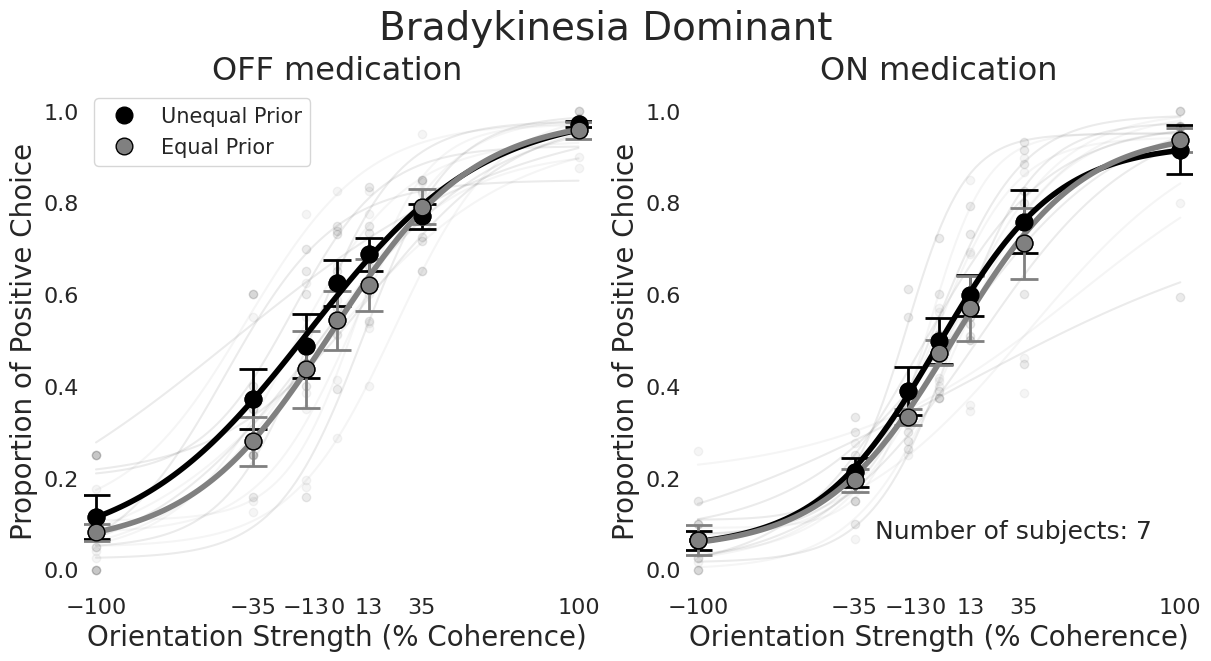

In [29]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors

for category in ['all', 'tremor_dominant', 'bradykinesia_dominant']:

    if category == 'all':
        subjects = np.concatenate([new_brady_subjects, new_trem_subjects, new_intermediate_subjects])#, original_all_subjects])
        subtitle = 'PD Patients'
    elif category == 'tremor_dominant':
        subjects = new_trem_subjects
        subtitle = 'Tremor Dominant'
    elif category == 'bradykinesia_dominant':
        subjects = new_brady_subjects
        subtitle = 'Bradykinesia Dominant'

    fig, ax = plt.subplots(1, 2, figsize=(12, 6.5))
    subject_alpha = 0.08
    positive_color = 'black'# 'C5'
    equal_color = 'gray'
    error_plot_style = {'elinewidth': 2, 'capsize': 10, 'capthick': 2}

    sub_off_pos_coh, sub_off_pos_psych, sub_off_pos_model, sub_off_pos_x_hat, sub_off_pos_y_hat = [], [], [], [], []
    sub_off_eq_coh, sub_off_eq_psych, sub_off_eq_model, sub_off_eq_x_hat, sub_off_eq_y_hat = [], [], [], [], []
    sub_on_pos_coh, sub_on_pos_psych, sub_on_pos_model, sub_on_pos_x_hat, sub_on_pos_y_hat = [], [], [], [], []
    sub_on_eq_coh, sub_on_eq_psych, sub_on_eq_model, sub_on_eq_x_hat, sub_on_eq_y_hat = [], [], [], [], []

    for i, subject in enumerate(subjects):
        subject_data = filtered_data[filtered_data['subject_id'] == subject]
        subject_data = subject_data.sort_values('medication')

        for idx, med in enumerate(subject_data['medication'].unique()):
            med_data = subject_data[subject_data['medication'] == med]
            pos_coh, pos_psych, pos_model, pos_x_hat, pos_y_hat = pmf_utils.get_psychometric_data(med_data[med_data['color'] == 1])
            eq_coh, eq_psych, eq_model, eq_x_hat, eq_y_hat  = pmf_utils.get_psychometric_data(med_data[med_data['color'] == -1])

            if med == 'off':
                ax_idx = 0
                sub_off_pos_coh.append(pos_coh)
                sub_off_pos_psych.append(pos_psych)
                sub_off_pos_model.append(pos_model)
                sub_off_pos_x_hat.append(pos_x_hat)
                sub_off_pos_y_hat.append(pos_y_hat)
                sub_off_eq_coh.append(eq_coh)
                sub_off_eq_psych.append(eq_psych)
                sub_off_eq_model.append(eq_model)
                sub_off_eq_x_hat.append(eq_x_hat)
                sub_off_eq_y_hat.append(eq_y_hat)
            elif med == 'on':
                ax_idx = 1
                sub_on_pos_coh.append(pos_coh)
                sub_on_pos_psych.append(pos_psych)
                sub_on_pos_model.append(pos_model)
                sub_on_pos_x_hat.append(pos_x_hat)
                sub_on_pos_y_hat.append(pos_y_hat)
                sub_on_eq_coh.append(eq_coh)
                sub_on_eq_psych.append(eq_psych)
                sub_on_eq_model.append(eq_model)
                sub_on_eq_x_hat.append(eq_x_hat)
                sub_on_eq_y_hat.append(eq_y_hat)

            ax[ax_idx].plot(pos_coh, pos_psych, color=positive_color, marker='o', ls='', alpha=subject_alpha)
            ax[ax_idx].plot(pos_x_hat, pos_y_hat, color=positive_color, ls='-', alpha=subject_alpha)
            ax[ax_idx].plot(eq_coh, eq_psych, color=equal_color, marker='o', ls='', alpha=subject_alpha)
            ax[ax_idx].plot(eq_x_hat, eq_y_hat, color=equal_color, ls='-', alpha=subject_alpha)


    ax[0].plot(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
    ax[0].plot(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
    ax[0].errorbar(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), yerr=stats.sem(sub_off_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    ax[0].errorbar(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), yerr=stats.sem(sub_off_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    pos_model = pmf_utils.fit_psychometric_function(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0))
    eq_model = pmf_utils.fit_psychometric_function(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0))
    ax[0].plot(np.mean(sub_off_pos_x_hat, axis=0), pos_model.predict(np.mean(sub_off_pos_x_hat, axis=0)), color=positive_color, ls='-', lw=4, alpha=1)
    ax[0].plot(np.mean(sub_off_eq_x_hat, axis=0), eq_model.predict(np.mean(sub_off_eq_x_hat, axis=0)), color=equal_color, ls='-', lw=4, alpha=1)


    ax[1].plot(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
    ax[1].plot(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
    ax[1].errorbar(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), yerr=stats.sem(sub_on_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    ax[1].errorbar(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), yerr=stats.sem(sub_on_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    pos_model = pmf_utils.fit_psychometric_function(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0))
    eq_model = pmf_utils.fit_psychometric_function(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0))
    ax[1].plot(np.mean(sub_on_pos_x_hat, axis=0), pos_model.predict(np.mean(sub_on_pos_x_hat, axis=0)), color=positive_color, ls='-', lw=4, alpha=1)
    ax[1].plot(np.mean(sub_on_eq_x_hat, axis=0), eq_model.predict(np.mean(sub_on_eq_x_hat, axis=0)), color=equal_color, ls='-', lw=4, alpha=1)


    ax[0].set_title(f"OFF medication", fontsize=23)
    ax[1].set_title(f"ON medication", fontsize=23)

    ax[0].legend(fontsize=15)

    for i in range(2):
        ax[i].set_xlabel('Orientation Strength (% Coherence)', fontsize=20)
        ax[i].set_ylabel('Proportion of Positive Choice', fontsize=20)
        ax[i].set_xlim(-105, 105)
        ax[i].set_ylim(-0.05, 1.05)
        ax[i].set_xticks([-100, -35, -13, 0, 13, 35, 100])
        ax[i].tick_params(axis='both', labelsize=16)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].grid(False)

    fig.suptitle(f"{subtitle}", fontsize=28)

    # Add a text annotation with the number of subjects
    fig.text(0.84, 0.18, f"Number of subjects: {len(subjects)}", ha='center', fontsize=18)
    # fig.text(0.35, 0.18, f"Number of subjects: {len(subjects)}", ha='center', fontsize=18)

    fig.tight_layout()
    plt.show()



In [30]:
temp_data = filtered_data.copy()
# rename response_time to reaction_time
temp_data = temp_data.rename(columns={'reaction_time':'response_time'})

In [31]:
subject_treatment_idx

,subject,off,on
0,P1,0,1
1,P3,2,3
2,P4,4,5
3,P6,6,7
4,P7,8,9
5,P9,11,10
6,P11,13,12
7,P12,15,14
8,P13,16,17
9,P17,18,19


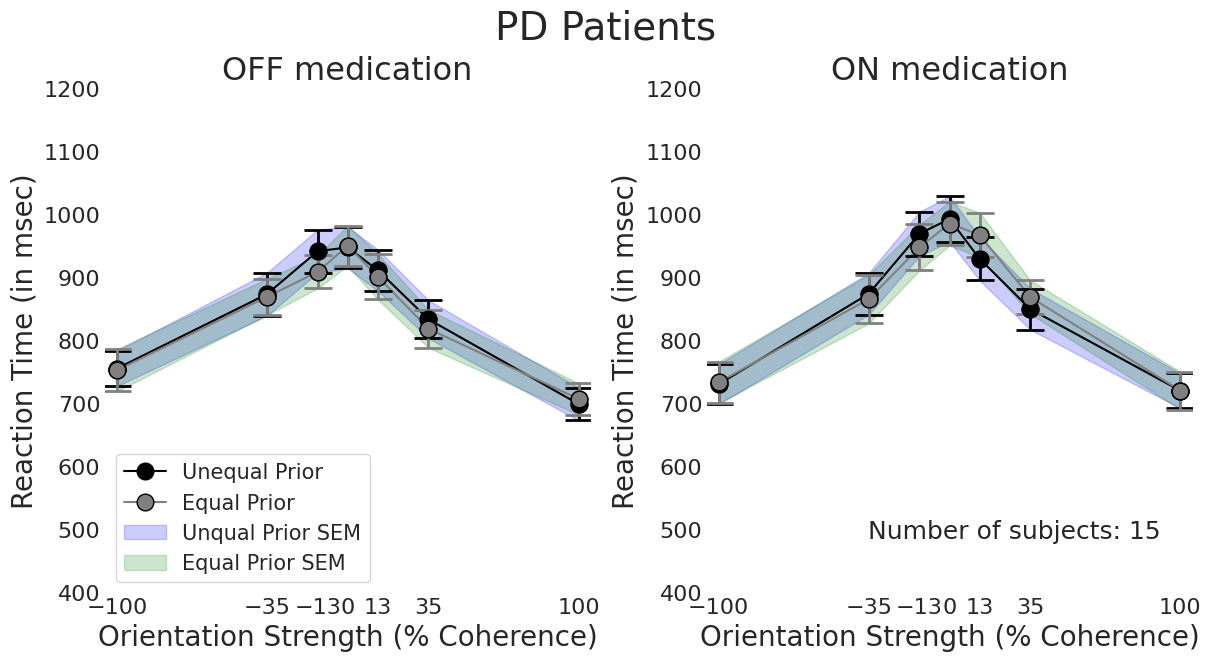

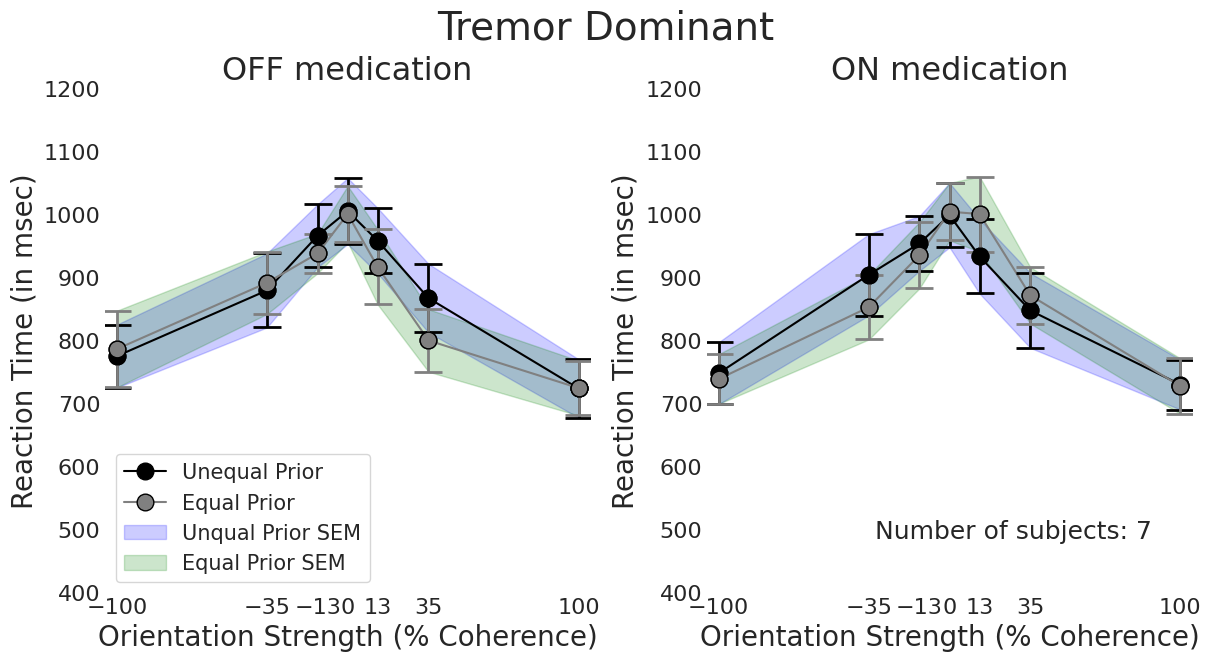

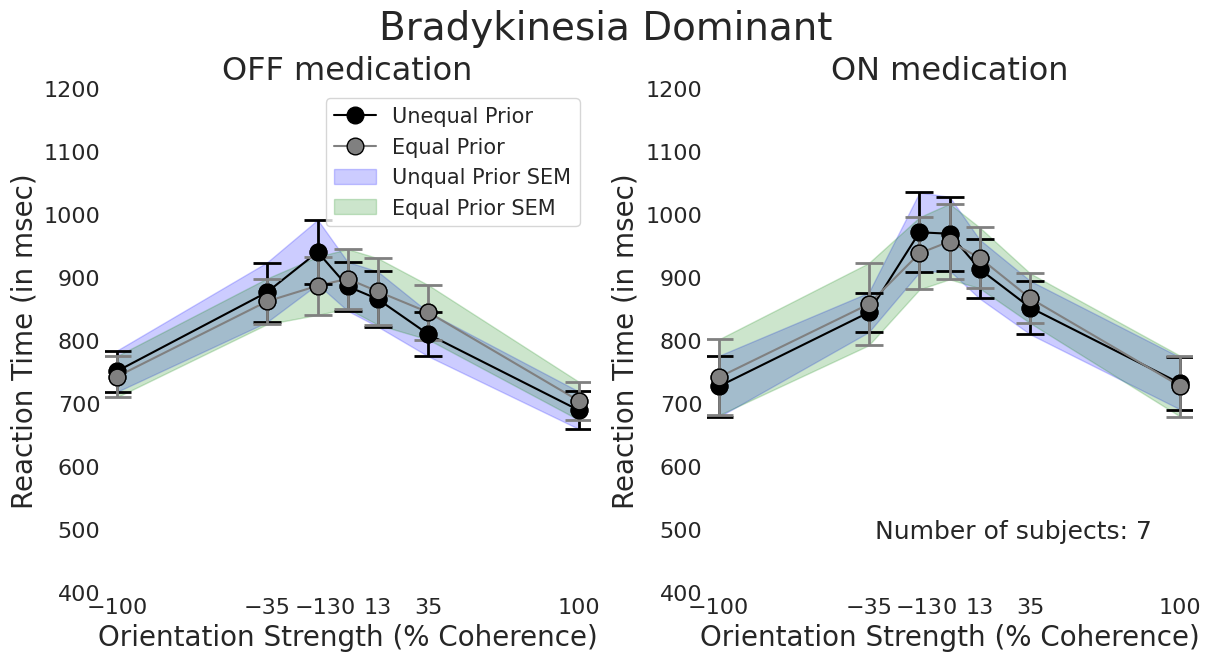

In [32]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors

# for category in ['all']:#, 'tremor_dominant', 'bradykinesia_dominant']:
for category in ['all', 'tremor_dominant', 'bradykinesia_dominant']:

    if category == 'all':
        subjects = np.concatenate([new_brady_subjects, new_trem_subjects, new_intermediate_subjects])#, original_all_subjects])
        subtitle = 'PD Patients'
    elif category == 'tremor_dominant':
        subjects = new_trem_subjects
        subtitle = 'Tremor Dominant'
    elif category == 'bradykinesia_dominant':
        subjects = new_brady_subjects
        subtitle = 'Bradykinesia Dominant'

    fig, ax = plt.subplots(1, 2, figsize=(12, 6.5))
    subject_alpha = 0.08
    positive_color = 'black'# 'C5'
    equal_color = 'gray'
    error_plot_style = {'elinewidth': 2, 'capsize': 10, 'capthick': 2}

    sub_off_pos_coh, sub_off_pos_chrono = [], []
    sub_off_eq_coh, sub_off_eq_chrono = [], []
    sub_on_pos_coh, sub_on_pos_chrono = [], []
    sub_on_eq_coh, sub_on_eq_chrono = [], []

    for i, subject in enumerate(subjects):
        subject_data = temp_data[temp_data['subject_id'] == subject]
        subject_data = subject_data.sort_values('medication')

        for idx, med in enumerate(subject_data['medication'].unique()):
            med_data = subject_data[subject_data['medication'] == med]
            pos_coh, pos_chrono = pmf_utils.get_chronometric_data(med_data[med_data['color'] == 1])
            eq_coh, eq_chrono = pmf_utils.get_chronometric_data(med_data[med_data['color'] == -1])

            if med == 'off':
                ax_idx = 0
                sub_off_pos_coh.append(pos_coh)
                sub_off_pos_chrono.append(pos_chrono)
                sub_off_eq_coh.append(eq_coh)
                sub_off_eq_chrono.append(eq_chrono)
            elif med == 'on':
                ax_idx = 1
                sub_on_pos_coh.append(pos_coh)
                sub_on_pos_chrono.append(pos_chrono)
                sub_on_eq_coh.append(eq_coh)
                sub_on_eq_chrono.append(eq_chrono)


    ax[0].plot(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_chrono, axis=0), color=positive_color, ls='-', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
    ax[0].plot(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_chrono, axis=0), color=equal_color, ls='-', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
    ax[0].errorbar(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_chrono, axis=0), yerr=stats.sem(sub_off_pos_chrono, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    ax[0].errorbar(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_chrono, axis=0), yerr=stats.sem(sub_off_eq_chrono, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    # fill between the error bars
    ax[0].fill_between(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_chrono, axis=0) - stats.sem(sub_off_pos_chrono, axis=0), np.mean(sub_off_pos_chrono, axis=0) + stats.sem(sub_off_pos_chrono, axis=0), color='blue', alpha=0.2, label='Unqual Prior SEM')
    ax[0].fill_between(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_chrono, axis=0) - stats.sem(sub_off_eq_chrono, axis=0), np.mean(sub_off_eq_chrono, axis=0) + stats.sem(sub_off_eq_chrono, axis=0), color='green', alpha=0.2, label='Equal Prior SEM')

    ax[1].plot(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_chrono, axis=0), color=positive_color, ls='-', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
    ax[1].plot(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_chrono, axis=0), color=equal_color, ls='-', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
    ax[1].errorbar(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_chrono, axis=0), yerr=stats.sem(sub_on_pos_chrono, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    ax[1].errorbar(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_chrono, axis=0), yerr=stats.sem(sub_on_eq_chrono, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    # fill between the error bars
    ax[1].fill_between(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_chrono, axis=0) - stats.sem(sub_on_pos_chrono, axis=0), np.mean(sub_on_pos_chrono, axis=0) + stats.sem(sub_on_pos_chrono, axis=0), color='blue', alpha=0.2)
    ax[1].fill_between(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_chrono, axis=0) - stats.sem(sub_on_eq_chrono, axis=0), np.mean(sub_on_eq_chrono, axis=0) + stats.sem(sub_on_eq_chrono, axis=0), color='green', alpha=0.2)


    ax[0].set_title(f"OFF medication", fontsize=23)
    ax[1].set_title(f"ON medication", fontsize=23)

    ax[0].legend(fontsize=15)

    for i in range(2):
        ax[i].set_xlabel('Orientation Strength (% Coherence)', fontsize=20)
        ax[i].set_ylabel('Reaction Time (in msec)', fontsize=20)
        ax[i].set_xlim(-105, 105)
        ax[i].set_ylim(400, 1200)
        ax[i].set_xticks([-100, -35, -13, 0, 13, 35, 100])
        ax[i].tick_params(axis='both', labelsize=16)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].grid(False)

    fig.suptitle(f"{subtitle}", fontsize=28)

    # Add a text annotation with the number of subjects
    fig.text(0.84, 0.18, f"Number of subjects: {len(subjects)}", ha='center', fontsize=18)
    # fig.text(0.35, 0.18, f"Number of subjects: {len(subjects)}", ha='center', fontsize=18)

    fig.tight_layout()
    plt.show()



### Categorization statistical analysis

In [33]:
brady_treatment_idx = subject_treatment_idx[subject_treatment_idx['subject'].isin(new_brady_subjects)]
trem_treatment_idx = subject_treatment_idx[subject_treatment_idx['subject'].isin(new_trem_subjects)]

In [34]:
from scipy.stats import wilcoxon

independent_variables = ['psych_alpha', 'psych_beta', 'psych_lapse', 'psych_guess']

print("Wilcoxon signed-rank test")

for subtype in ['tremor_dominant', 'bradykinesia_dominant']:


    print("---------------------------------------------------")
    if subtype == 'tremor_dominant':
        treatment_idx = trem_treatment_idx
        print("Tremor Dominant")
    elif subtype == 'bradykinesia_dominant':
        treatment_idx = brady_treatment_idx
        print("Bradykinesia Dominant")
    for independent_variable in independent_variables:
        # OFF medication
        off_positive_variables = processed_metadata.loc[treatment_idx['off']][f'positive_{independent_variable}']
        off_equal_variables = processed_metadata.loc[treatment_idx['off']][f'equal_{independent_variable}']
        # ON medication
        on_positive_variables = processed_metadata.loc[treatment_idx['on']][f'positive_{independent_variable}']
        on_equal_variables = processed_metadata.loc[treatment_idx['on']][f'equal_{independent_variable}']


        # Wilcoxon signed-rank test
        print(f" {independent_variable} OFF medication \t\t W-statistic: {stats.wilcoxon(off_positive_variables, off_equal_variables)[0]:.3f}, p-value: {stats.wilcoxon(off_positive_variables, off_equal_variables)[1]:.3f}")
        print(f" {independent_variable} ON medication \t\t W-statistic: {stats.wilcoxon(on_positive_variables, on_equal_variables)[0]:.3f}, p-value: {stats.wilcoxon(on_positive_variables, on_equal_variables)[1]:.3f}")


Wilcoxon signed-rank test
---------------------------------------------------
Tremor Dominant
 psych_alpha OFF medication 		 W-statistic: 6.000, p-value: 0.219
 psych_alpha ON medication 		 W-statistic: 2.000, p-value: 0.047
 psych_beta OFF medication 		 W-statistic: 0.000, p-value: 0.016
 psych_beta ON medication 		 W-statistic: 10.000, p-value: 0.578
 psych_lapse OFF medication 		 W-statistic: 10.000, p-value: 1.000
 psych_lapse ON medication 		 W-statistic: 13.000, p-value: 0.938
 psych_guess OFF medication 		 W-statistic: 12.000, p-value: 0.812
 psych_guess ON medication 		 W-statistic: 9.000, p-value: 0.469
---------------------------------------------------
Bradykinesia Dominant
 psych_alpha OFF medication 		 W-statistic: 12.000, p-value: 0.812
 psych_alpha ON medication 		 W-statistic: 7.000, p-value: 0.297
 psych_beta OFF medication 		 W-statistic: 12.000, p-value: 0.812
 psych_beta ON medication 		 W-statistic: 13.000, p-value: 0.938
 psych_lapse OFF medication 		 W-statistic: